# Dataset Source

[Kaggle dataset source](https://www.kaggle.com/mlg-ulb/creditcardfraud)

# Import modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

%matplotlib inline

Using TensorFlow backend.


# Constants

In [2]:
LABEL_NAMES = ['Not Fraud','Fraud']

# Check for missing data

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<AxesSubplot:>

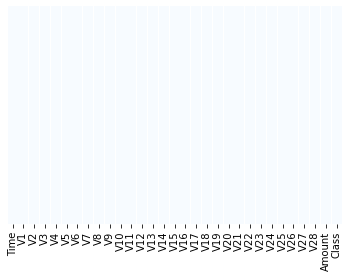

In [6]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

### Drop rows with transactions for amount zero

In [7]:
i=df[df['Amount']==0].index
df.drop(i,inplace=True)

In [8]:
#drop time column
df.drop('Time',axis=1,inplace=True)

# Checking the number of fraudulent and non-fraudulent transactions

In [9]:
df['Class'].value_counts()

0    282517
1       465
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

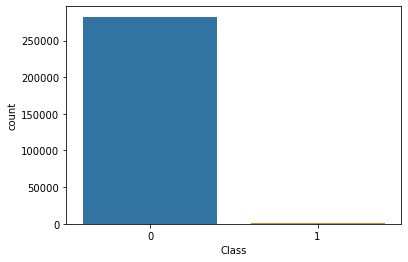

In [10]:
sns.countplot(x = 'Class', data = df)

# Check the amount of money on the all transactions

In [11]:
df['Amount'].describe()

count    282982.000000
mean         88.919401
std         250.824374
min           0.010000
25%           5.990000
50%          22.490000
75%          78.000000
max       25691.160000
Name: Amount, dtype: float64

#### Check the type of transaction for the max amount

In [12]:
class_max=df[df['Amount']==25691.160000]['Class'].values[0]

print(f'The class of transaction was {class_max}')

The class of transaction was 0


<AxesSubplot:ylabel='Frequency'>

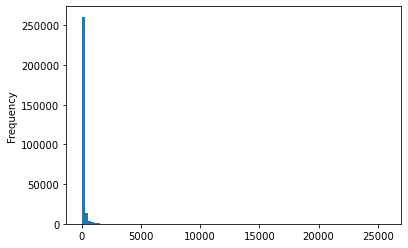

In [13]:
df['Amount'].plot(bins=100, kind='hist')

# Checking the fraudulent transactions

In [14]:
fraud_df=df[df['Class']==1]

<AxesSubplot:ylabel='Frequency'>

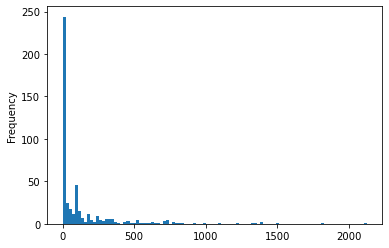

In [15]:
fraud_df['Amount'].plot(bins=100, kind='hist')

In [16]:
mean_fraud = fraud_df['Amount'].mean()
max_fraud = fraud_df['Amount'].max()
min_fraud = fraud_df['Amount'].min()
print(f'The mean value for fradulent transaction is {mean_fraud:.2f}')
print(f'The max value for fradulent transaction is {max_fraud:.2f}')
print(f'The min value for fradulent transaction is {min_fraud:.2f}')

The mean value for fradulent transaction is 129.31
The max value for fradulent transaction is 2125.87
The min value for fradulent transaction is 0.01


# Relationships among the variables

In [17]:
df.corr()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
V1,1.000000,-0.002055,-0.000331,0.000920,0.002899,-0.001794,-0.004836,-0.002666,-0.001694,-0.002228,...,-0.003140,0.000473,0.002885,-0.000265,-0.000360,0.000101,0.000523,-0.001963,-0.228698,-0.100950
V2,-0.002055,1.000000,0.000536,-0.002232,0.004503,-0.003443,-0.000207,0.001741,0.002865,0.001578,...,0.000189,-0.000649,0.003824,0.000062,0.001222,-0.000568,0.003271,-0.001836,-0.533166,0.089696
V3,-0.000331,0.000536,1.000000,-0.002884,-0.000676,-0.002038,-0.001844,-0.002313,-0.001702,-0.004259,...,-0.002051,0.000413,0.001784,-0.000180,0.000233,-0.000072,0.000163,-0.000602,-0.211159,-0.190199
V4,0.000920,-0.002232,-0.002884,1.000000,-0.002190,-0.003669,0.006133,0.000349,0.004698,-0.004887,...,0.000977,-0.003057,-0.001224,0.000791,-0.000248,-0.002588,-0.000170,0.001311,0.102891,0.130052
V5,0.002899,0.004503,-0.000676,-0.002190,1.000000,0.002138,-0.000393,-0.000731,0.000449,-0.002695,...,-0.000889,0.000187,-0.001271,0.000853,-0.000893,-0.000835,-0.001213,0.001361,-0.387583,-0.096833
V6,-0.001794,-0.003443,-0.002038,-0.003669,0.002138,1.000000,0.000686,0.000760,0.000623,-0.001917,...,0.000769,-0.001282,0.001002,0.001172,0.000720,0.000219,0.001169,-0.000708,0.217221,-0.042167
V7,-0.004836,-0.000207,-0.001844,0.006133,-0.000393,0.000686,1.000000,-0.005451,-0.001890,-0.003592,...,-0.004751,0.002204,0.001285,-0.000391,-0.000436,0.000786,0.000178,-0.000541,0.399049,-0.184753
V8,-0.002666,0.001741,-0.002313,0.000349,-0.000731,0.000760,-0.005451,1.000000,-0.001456,-0.002307,...,-0.006747,0.002673,0.001828,-0.000088,0.000165,0.000799,-0.000516,-0.000168,-0.103737,0.020931
V9,-0.001694,0.002865,-0.001702,0.004698,0.000449,0.000623,-0.001890,-0.001456,1.000000,-0.001091,...,-0.001080,0.000836,-0.000594,-0.000352,-0.000457,0.001262,-0.000682,0.000204,-0.044861,-0.093515
V10,-0.002228,0.001578,-0.004259,-0.004887,-0.002695,-0.001917,-0.003592,-0.002307,-0.001091,1.000000,...,-0.002825,-0.000388,-0.000031,0.000067,0.000459,-0.000233,0.000599,0.000740,-0.101246,-0.212381


In [18]:
mask = np.zeros_like(df.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

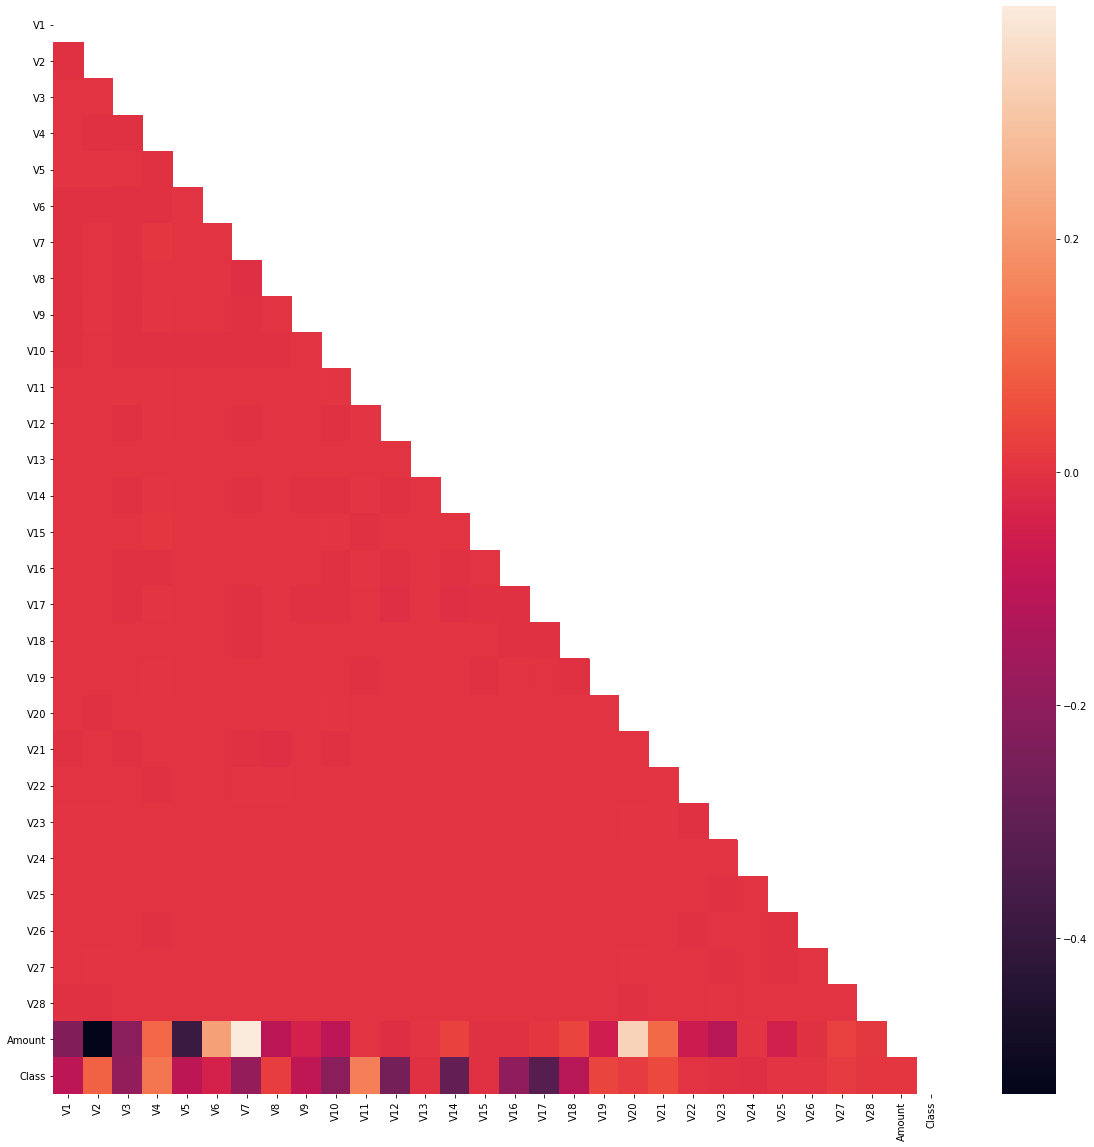

In [19]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),mask=mask, annot=False, annot_kws={'size':14})
plt.show()

### Training and Test split

In [20]:
X = df.loc[:,df.columns != 'Class']
y = df['Class']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Feature Scaling

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [24]:
X_train.shape

(226385, 29)

In [25]:
X_test.shape

(56597, 29)

## Try the logistic model

In [26]:
model = LogisticRegression(random_state = 101)
model.fit(X_train, y_train)

LogisticRegression(random_state=101)

## Confusion Matrix

In [27]:
def plot_cm(cm, resolution, labels,NR_CLASSES=2):
    plt.figure(figsize=(3,3), dpi=resolution)
    plt.imshow(cm, cmap=plt.cm.Greens)
    plt.title("Confusion Matrix", fontsize=12)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.xlabel("Predicted Labels", fontsize=10)

    tick_marks = np.arange(NR_CLASSES)
    plt.yticks(tick_marks, labels)
    plt.xticks(tick_marks, labels)

    plt.colorbar()

    for i, j in itertools.product(range(NR_CLASSES),range(NR_CLASSES)):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
            color='white' if cm[i,j]>1000 else 'black')
    return plt.show()

In [28]:
cm = confusion_matrix(y_test, model.predict(X_test))
cm.shape

(2, 2)

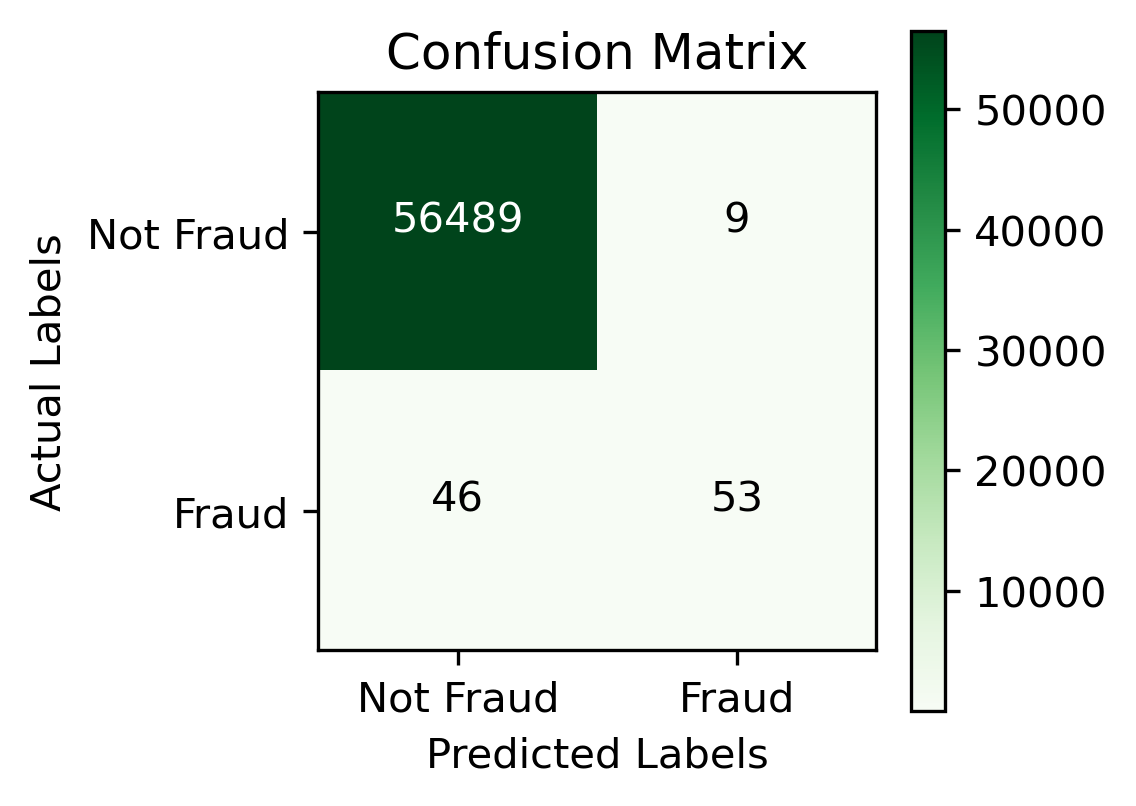

In [29]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)

In [30]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56498
           1       0.85      0.54      0.66        99

    accuracy                           1.00     56597
   macro avg       0.93      0.77      0.83     56597
weighted avg       1.00      1.00      1.00     56597



In [31]:
accuracy_score(y_test, model.predict(X_test))

0.9990282170433061

##### There is a problem with this data regarding the umbalanced classification. Since the number of fradululent transactions is very short comparing to the genuine transactions, the problem has to be dealt in a different way because the logistic models assume those transactions as noise . In this way, it should be employed undersampling or oversampling techniques

# Undersampling 

In [32]:
# shuffle data
df.sample(frac=1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
228521,-0.925935,1.403307,-0.747551,-0.811483,2.308663,-1.342309,1.623194,-0.180838,-1.269179,-2.014693,...,0.004943,-0.080914,-0.666732,0.586294,1.239062,0.697984,-0.087711,0.078854,0.76,0
140844,-1.206282,1.030093,1.003453,0.298593,1.092285,-0.597692,0.699355,-0.268427,-0.451728,0.094546,...,0.028673,0.289987,-0.514870,-0.398775,0.327676,-0.343546,0.025874,0.212083,10.87,0
216855,2.111880,-1.091185,-0.435411,-0.963659,-1.053827,-0.046591,-1.273994,0.113761,-0.035688,0.898480,...,0.513534,1.517906,0.090679,0.823766,-0.108243,-0.017891,0.010088,-0.048869,16.31,0
206774,2.093077,0.565093,-2.688417,0.591722,0.936169,-1.290806,0.349961,-0.340772,0.548836,-1.208509,...,0.054068,0.373980,-0.135668,-0.987979,0.346697,-0.050539,0.022725,-0.000294,1.00,0
69953,1.310496,0.529888,-0.449133,0.911155,0.542068,-0.686516,0.641252,-0.380943,-0.418913,0.002478,...,-0.028909,0.012280,-0.277061,-0.411090,1.003017,-0.249610,-0.003034,0.007478,15.19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99173,-3.540103,2.429401,0.110577,2.200371,-0.087424,0.633476,-0.275668,0.828080,-0.158593,3.361102,...,-0.462575,-0.557725,-0.266039,-0.854273,0.027056,-0.057526,-0.136053,0.136399,1.52,0
52074,1.165930,-1.148826,1.129100,-0.737028,-1.701583,0.001785,-1.366499,0.223595,-0.317690,0.732263,...,0.509594,1.171448,-0.201757,0.045305,0.273956,-0.046912,0.032912,0.033267,97.21,0
151242,-0.468277,1.644170,-0.687690,-0.597847,1.041688,-0.639000,0.991093,-0.334746,1.783018,0.247794,...,0.072345,0.966934,-0.226073,-1.014413,-0.493128,-0.185599,0.802710,0.486786,0.89,0
167166,-0.404725,-5.664884,-4.305101,-0.641238,-1.373189,-0.441574,1.803663,-0.808640,-2.414818,1.258795,...,1.008548,0.059816,-1.441846,0.464393,0.135538,0.119014,-0.357890,0.156190,1464.75,0


In [33]:
fraud_df = df.loc[df['Class']==1]
fraud_df.shape[0]

465

In [34]:
non_fraud_df = df.loc[df['Class']==0][:465]

In [35]:
balanced_df = pd.concat([fraud_df, non_fraud_df]).sample(frac=1,random_state=101)

In [36]:
balanced_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
244333,-5.222968,4.641827,-8.858204,7.723502,-1.507035,-2.159484,-4.205164,0.979334,-1.505637,-2.239066,...,0.561892,0.624207,0.536429,-0.628334,-0.222651,0.382208,-2.693036,0.407935,1.00,1
153885,-6.985267,5.151094,-4.599338,4.534479,0.849054,-0.210701,-4.425230,-5.134525,0.069321,-0.870997,...,5.453672,-2.056177,-0.280334,0.120771,0.569358,0.145971,0.300193,1.779364,0.76,1
214775,-0.395582,-0.751792,-1.984666,-0.203459,1.903967,-1.430289,-0.076548,-0.992260,0.756307,0.217630,...,1.377515,2.151787,0.189225,0.772943,-0.872443,-0.200612,0.356856,0.032113,0.69,1
35,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.925997,-0.358099,1.376722,1.900769,-1.057690,0.301885,-0.462266,0.250424,1.253958,-0.436371,...,-0.347567,-0.676807,0.100568,0.595989,0.322122,-0.547495,0.078786,0.043819,70.60,0
373,0.867479,-1.102252,0.608959,0.826675,-1.246214,0.072492,-0.509153,0.087330,-0.464954,0.643826,...,-0.242823,-0.556613,-0.110148,0.025722,0.263809,-0.324195,0.042550,0.063652,208.38,0
157868,-1.532810,2.232752,-5.923100,3.386708,-0.153443,-1.419748,-3.878576,1.444656,-1.465542,-5.208335,...,0.632505,-0.070838,-0.490291,-0.359983,0.050678,1.095671,0.471741,-0.106667,0.76,1
58,1.110692,0.081942,0.406063,1.290740,-0.169813,0.120955,-0.080845,0.174373,0.152071,0.065267,...,-0.056024,-0.011603,-0.070483,0.004345,0.603929,-0.327424,0.029890,0.004944,13.84,0


In [37]:
mask = np.zeros_like(balanced_df.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

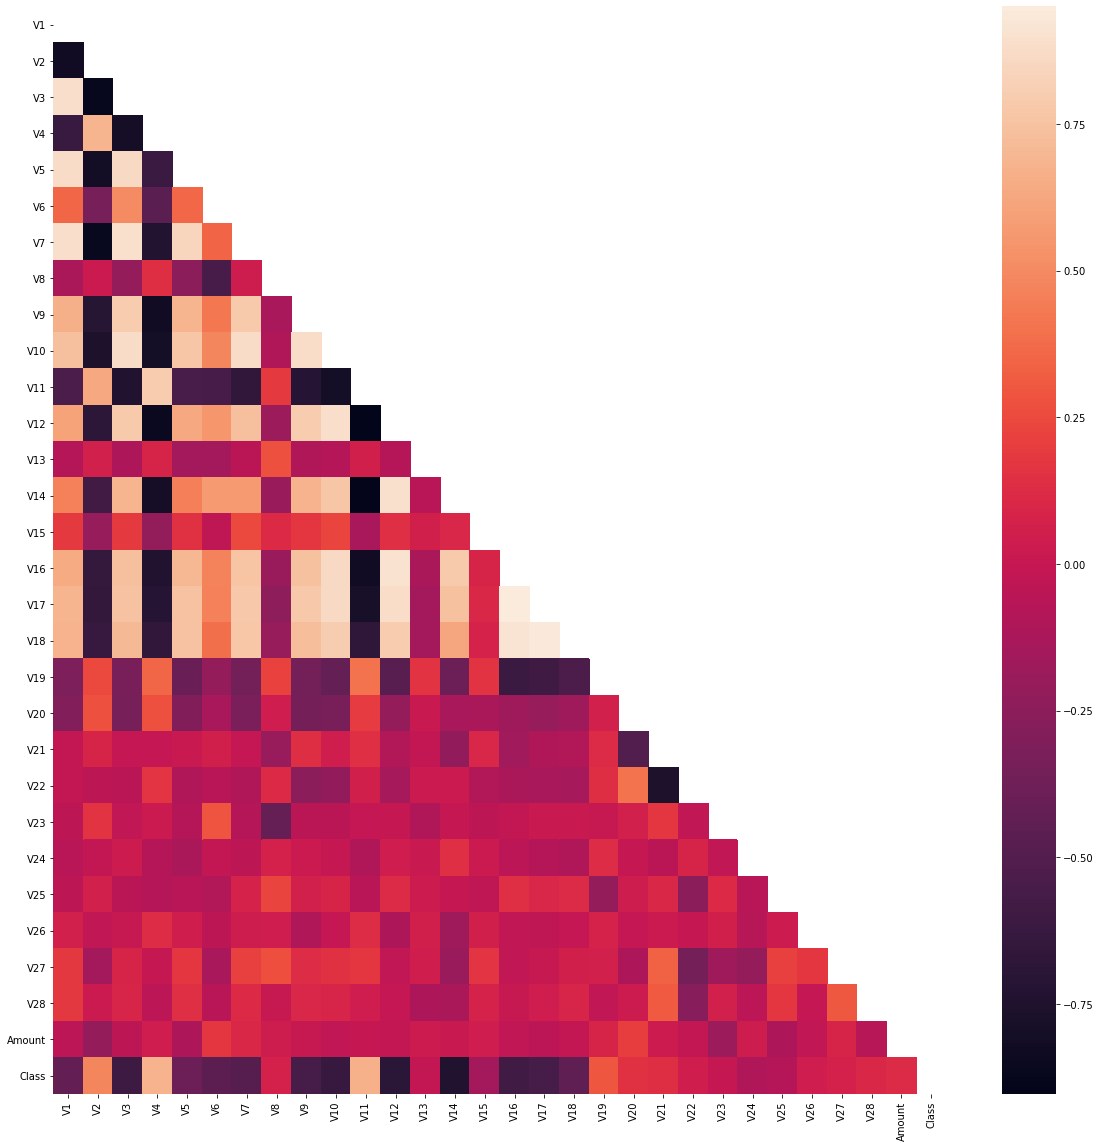

In [38]:
plt.figure(figsize=(20,20))
sns.heatmap(balanced_df.corr(),mask=mask, annot=False, annot_kws={'size':14})
plt.show()

In [39]:
corr_Class=balanced_df.corr()['Class']

In [40]:
corr_Class[corr_Class>0.5]

V4       0.680084
V11      0.673375
Class    1.000000
Name: Class, dtype: float64

In [41]:
neg_corr = corr_Class[corr_Class<-0.5]
neg_corr.index

Index(['V3', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17'], dtype='object')

<AxesSubplot:xlabel='Class', ylabel='V4'>

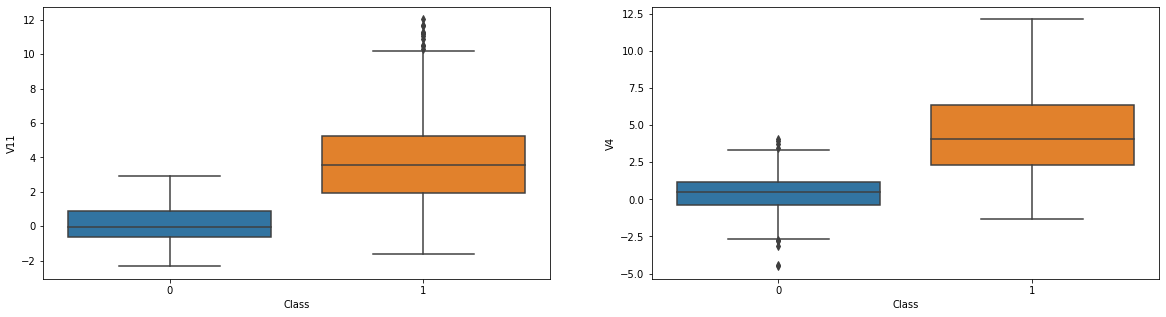

In [42]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.boxplot(x='Class',y='V11',data=balanced_df)
plt.subplot(1,2,2)
sns.boxplot(x='Class',y='V4',data=balanced_df)

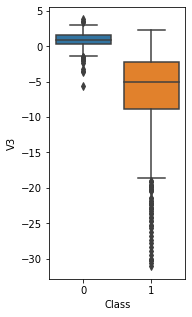

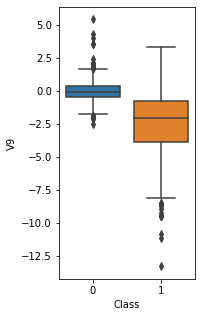

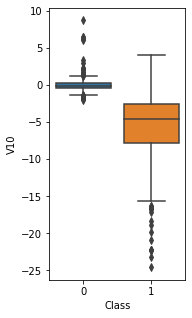

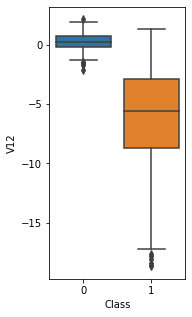

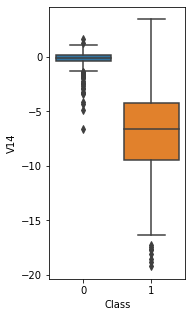

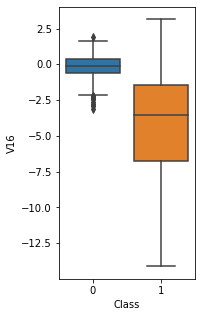

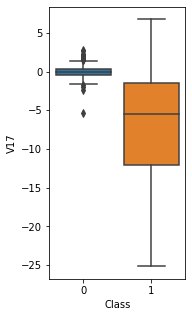

In [43]:
for i in range(1, len(neg_corr.values)+1):
    plt.figure(figsize=(20,5))
    plt.subplot(1,len(neg_corr.values),i)
    sns.boxplot(x='Class',y=neg_corr.index[i-1],data=balanced_df)


#### lower values indicates a more likely fraudulent transaction for negative correlation. On the other hand, for positive correlations it is more likely to have fraudulent transactions for higher values

In [44]:
Q1 = balanced_df.quantile(0.75)
Q3 = balanced_df.quantile(0.25)

In [45]:
dist = Q1-Q3

In [46]:
upper = Q1 - 1.5*dist 

In [47]:
lower = Q3 + 1.5*dist

In [48]:
balanced_df = balanced_df[((balanced_df<upper) | (balanced_df>lower)).any(axis=1)] 

# Perform again training test split

In [49]:
X = balanced_df.loc[:,balanced_df.columns != 'Class']
y = balanced_df['Class']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling 

In [51]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Logistic Regression

In [52]:
model = LogisticRegression(random_state = 101)
model.fit(X_train, y_train)

LogisticRegression(random_state=101)

In [53]:
cm = confusion_matrix(y_test, model.predict(X_test))
cm.shape

(2, 2)

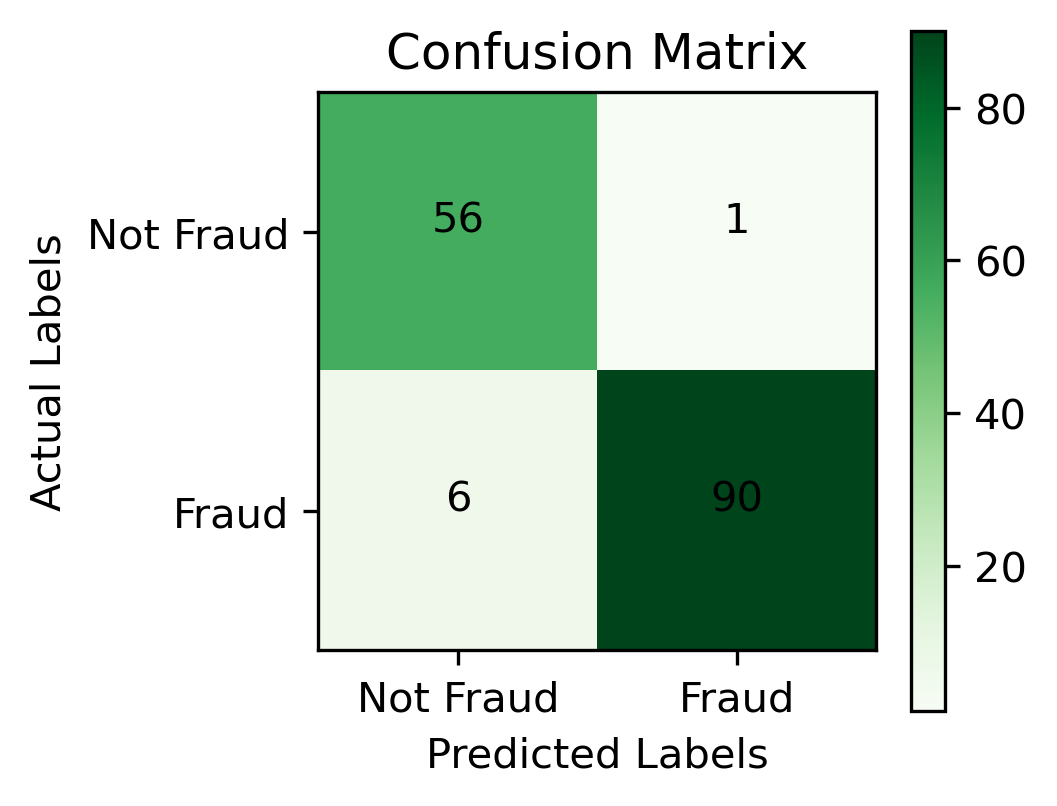

In [54]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)

In [55]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        57
           1       0.99      0.94      0.96        96

    accuracy                           0.95       153
   macro avg       0.95      0.96      0.95       153
weighted avg       0.96      0.95      0.95       153



In [56]:
accuracy_score(y_test,model.predict(X_test))

0.954248366013072

# Decision Tree

In [57]:
model_tree = DecisionTreeClassifier()

In [58]:
model_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [59]:
cm = confusion_matrix(y_test, model_tree.predict(X_test))
cm.shape

(2, 2)

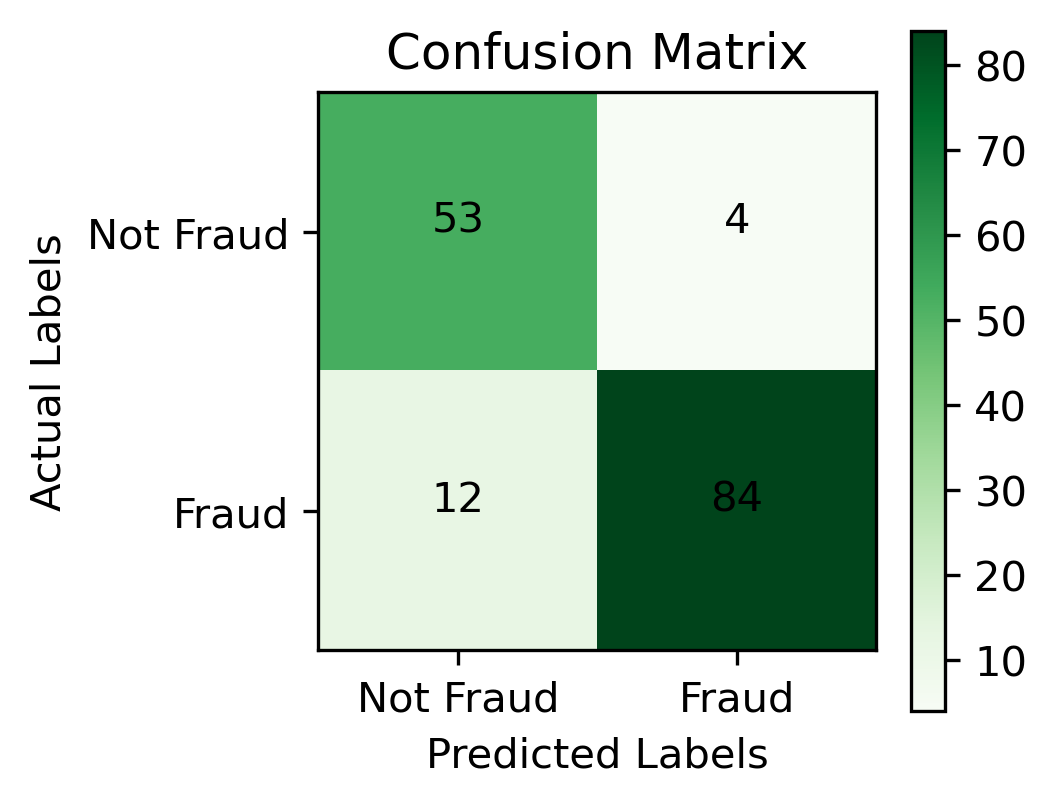

In [60]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)

In [61]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        57
           1       0.99      0.94      0.96        96

    accuracy                           0.95       153
   macro avg       0.95      0.96      0.95       153
weighted avg       0.96      0.95      0.95       153



# CatBoost

In [62]:
# !pip install catboost

In [63]:
model_cat = CatBoostClassifier()
model_cat.fit(X_train, y_train)

Learning rate set to 0.008336
0:	learn: 0.6801620	total: 59.9ms	remaining: 59.9s
1:	learn: 0.6685104	total: 64.4ms	remaining: 32.2s
2:	learn: 0.6569134	total: 68.8ms	remaining: 22.9s
3:	learn: 0.6451074	total: 72.9ms	remaining: 18.2s
4:	learn: 0.6351752	total: 77.1ms	remaining: 15.3s
5:	learn: 0.6246394	total: 81.3ms	remaining: 13.5s
6:	learn: 0.6139300	total: 85.5ms	remaining: 12.1s
7:	learn: 0.6037152	total: 90.3ms	remaining: 11.2s
8:	learn: 0.5930062	total: 94.5ms	remaining: 10.4s
9:	learn: 0.5848466	total: 98.6ms	remaining: 9.76s
10:	learn: 0.5732513	total: 102ms	remaining: 9.13s
11:	learn: 0.5645589	total: 106ms	remaining: 8.75s
12:	learn: 0.5548133	total: 112ms	remaining: 8.48s
13:	learn: 0.5457387	total: 117ms	remaining: 8.22s
14:	learn: 0.5360761	total: 122ms	remaining: 8s
15:	learn: 0.5265118	total: 127ms	remaining: 7.8s
16:	learn: 0.5164108	total: 132ms	remaining: 7.62s
17:	learn: 0.5076031	total: 136ms	remaining: 7.44s
18:	learn: 0.4984935	total: 141ms	remaining: 7.3s
19:	le

161:	learn: 0.1070051	total: 1.07s	remaining: 5.53s
162:	learn: 0.1062396	total: 1.08s	remaining: 5.53s
163:	learn: 0.1054208	total: 1.08s	remaining: 5.53s
164:	learn: 0.1046270	total: 1.09s	remaining: 5.53s
165:	learn: 0.1041363	total: 1.1s	remaining: 5.52s
166:	learn: 0.1034179	total: 1.11s	remaining: 5.52s
167:	learn: 0.1026912	total: 1.11s	remaining: 5.52s
168:	learn: 0.1022339	total: 1.12s	remaining: 5.51s
169:	learn: 0.1018172	total: 1.13s	remaining: 5.5s
170:	learn: 0.1012314	total: 1.13s	remaining: 5.5s
171:	learn: 0.1006902	total: 1.14s	remaining: 5.49s
172:	learn: 0.1002102	total: 1.15s	remaining: 5.48s
173:	learn: 0.0995710	total: 1.15s	remaining: 5.47s
174:	learn: 0.0989535	total: 1.16s	remaining: 5.47s
175:	learn: 0.0983983	total: 1.17s	remaining: 5.46s
176:	learn: 0.0978255	total: 1.17s	remaining: 5.45s
177:	learn: 0.0972383	total: 1.18s	remaining: 5.45s
178:	learn: 0.0965685	total: 1.19s	remaining: 5.44s
179:	learn: 0.0958532	total: 1.19s	remaining: 5.43s
180:	learn: 0.0

343:	learn: 0.0452048	total: 2.34s	remaining: 4.46s
344:	learn: 0.0450749	total: 2.35s	remaining: 4.45s
345:	learn: 0.0448685	total: 2.35s	remaining: 4.45s
346:	learn: 0.0446738	total: 2.36s	remaining: 4.44s
347:	learn: 0.0445222	total: 2.37s	remaining: 4.44s
348:	learn: 0.0443579	total: 2.38s	remaining: 4.43s
349:	learn: 0.0442259	total: 2.38s	remaining: 4.43s
350:	learn: 0.0440846	total: 2.39s	remaining: 4.42s
351:	learn: 0.0439538	total: 2.4s	remaining: 4.42s
352:	learn: 0.0437332	total: 2.41s	remaining: 4.41s
353:	learn: 0.0435960	total: 2.42s	remaining: 4.41s
354:	learn: 0.0434466	total: 2.42s	remaining: 4.4s
355:	learn: 0.0433326	total: 2.43s	remaining: 4.4s
356:	learn: 0.0431495	total: 2.44s	remaining: 4.39s
357:	learn: 0.0429794	total: 2.45s	remaining: 4.39s
358:	learn: 0.0428342	total: 2.46s	remaining: 4.38s
359:	learn: 0.0427047	total: 2.46s	remaining: 4.38s
360:	learn: 0.0425038	total: 2.47s	remaining: 4.37s
361:	learn: 0.0424120	total: 2.48s	remaining: 4.37s
362:	learn: 0.0

518:	learn: 0.0261755	total: 3.59s	remaining: 3.33s
519:	learn: 0.0261208	total: 3.6s	remaining: 3.32s
520:	learn: 0.0260754	total: 3.6s	remaining: 3.31s
521:	learn: 0.0260033	total: 3.61s	remaining: 3.31s
522:	learn: 0.0259419	total: 3.62s	remaining: 3.3s
523:	learn: 0.0258689	total: 3.63s	remaining: 3.29s
524:	learn: 0.0258204	total: 3.63s	remaining: 3.29s
525:	learn: 0.0257084	total: 3.64s	remaining: 3.28s
526:	learn: 0.0256340	total: 3.65s	remaining: 3.27s
527:	learn: 0.0255683	total: 3.65s	remaining: 3.26s
528:	learn: 0.0254794	total: 3.66s	remaining: 3.26s
529:	learn: 0.0254207	total: 3.67s	remaining: 3.25s
530:	learn: 0.0253353	total: 3.67s	remaining: 3.24s
531:	learn: 0.0252533	total: 3.68s	remaining: 3.23s
532:	learn: 0.0251936	total: 3.68s	remaining: 3.23s
533:	learn: 0.0251351	total: 3.69s	remaining: 3.22s
534:	learn: 0.0250555	total: 3.7s	remaining: 3.21s
535:	learn: 0.0249677	total: 3.71s	remaining: 3.21s
536:	learn: 0.0249307	total: 3.71s	remaining: 3.2s
537:	learn: 0.024

699:	learn: 0.0167967	total: 4.84s	remaining: 2.08s
700:	learn: 0.0167622	total: 4.85s	remaining: 2.07s
701:	learn: 0.0167364	total: 4.86s	remaining: 2.06s
702:	learn: 0.0167102	total: 4.87s	remaining: 2.06s
703:	learn: 0.0166820	total: 4.87s	remaining: 2.05s
704:	learn: 0.0166340	total: 4.88s	remaining: 2.04s
705:	learn: 0.0165987	total: 4.88s	remaining: 2.03s
706:	learn: 0.0165692	total: 4.89s	remaining: 2.03s
707:	learn: 0.0165327	total: 4.9s	remaining: 2.02s
708:	learn: 0.0164997	total: 4.91s	remaining: 2.01s
709:	learn: 0.0164770	total: 4.91s	remaining: 2.01s
710:	learn: 0.0164283	total: 4.92s	remaining: 2s
711:	learn: 0.0163833	total: 4.93s	remaining: 1.99s
712:	learn: 0.0163475	total: 4.93s	remaining: 1.99s
713:	learn: 0.0163067	total: 4.94s	remaining: 1.98s
714:	learn: 0.0162709	total: 4.95s	remaining: 1.97s
715:	learn: 0.0162327	total: 4.95s	remaining: 1.96s
716:	learn: 0.0161996	total: 4.96s	remaining: 1.96s
717:	learn: 0.0161711	total: 4.96s	remaining: 1.95s
718:	learn: 0.01

860:	learn: 0.0119524	total: 5.93s	remaining: 958ms
861:	learn: 0.0119334	total: 5.94s	remaining: 951ms
862:	learn: 0.0119166	total: 5.95s	remaining: 944ms
863:	learn: 0.0118967	total: 5.96s	remaining: 937ms
864:	learn: 0.0118774	total: 5.96s	remaining: 930ms
865:	learn: 0.0118609	total: 5.97s	remaining: 923ms
866:	learn: 0.0118405	total: 5.97s	remaining: 916ms
867:	learn: 0.0118147	total: 5.98s	remaining: 910ms
868:	learn: 0.0117935	total: 5.99s	remaining: 903ms
869:	learn: 0.0117682	total: 5.99s	remaining: 896ms
870:	learn: 0.0117345	total: 6s	remaining: 889ms
871:	learn: 0.0117222	total: 6s	remaining: 882ms
872:	learn: 0.0117012	total: 6.01s	remaining: 875ms
873:	learn: 0.0116851	total: 6.02s	remaining: 868ms
874:	learn: 0.0116664	total: 6.02s	remaining: 860ms
875:	learn: 0.0116469	total: 6.03s	remaining: 853ms
876:	learn: 0.0116165	total: 6.04s	remaining: 846ms
877:	learn: 0.0115984	total: 6.04s	remaining: 839ms
878:	learn: 0.0115677	total: 6.05s	remaining: 832ms
879:	learn: 0.0115

In [64]:
cm = confusion_matrix(y_test, model_cat.predict(X_test))
cm.shape

(2, 2)

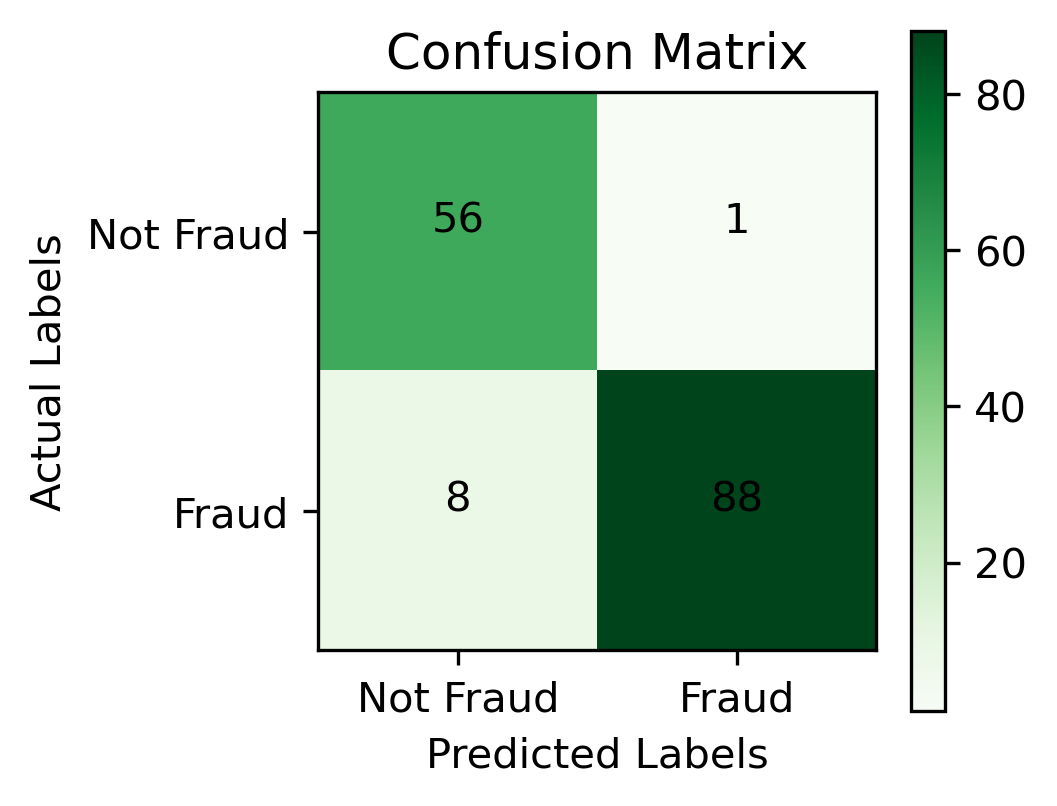

In [65]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)

In [66]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        57
           1       0.99      0.94      0.96        96

    accuracy                           0.95       153
   macro avg       0.95      0.96      0.95       153
weighted avg       0.96      0.95      0.95       153



# XGBoost

In [67]:
# !pip install xgboost

In [68]:
model_xgb = xgb.XGBClassifier()

In [69]:
model_xgb.fit(X_train, y_train)

[21:09:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Ana3\envs\tensorflow_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
cm = confusion_matrix(y_test, model_xgb.predict(X_test))
cm.shape

(2, 2)

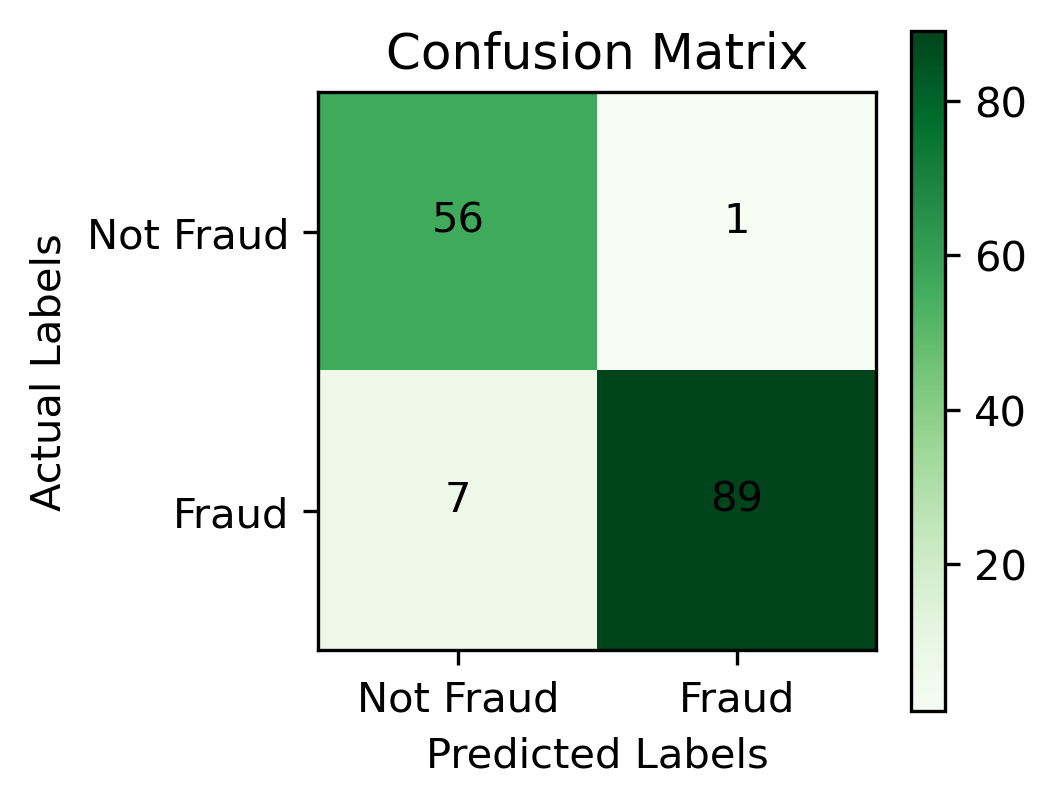

In [71]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)

In [72]:
print(classification_report(y_test, model_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        57
           1       0.99      0.93      0.96        96

    accuracy                           0.95       153
   macro avg       0.94      0.95      0.95       153
weighted avg       0.95      0.95      0.95       153



#### Among all ML models used, the logistic model was slighly better

# Oversampling 

## SMOTE

In [73]:
# pip install imbalanced-learn

In [74]:
X = df.loc[:,df.columns != 'Class']
y = df['Class']

In [79]:
sm=SMOTE(random_state=101)

In [80]:
X_resample, y_resample = sm.fit_resample(X,y)

In [81]:
y_resample = pd.DataFrame(y_resample)
X_resample = pd.DataFrame(X_resample)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_resample,y_resample,test_size=0.3)

In [83]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Logistic Regression

In [90]:
y_train.values.ravel()

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [93]:
model = LogisticRegression(random_state = 101, max_iter=200)
model.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=200, random_state=101)

In [94]:
cm = confusion_matrix(y_test, model.predict(X_test))

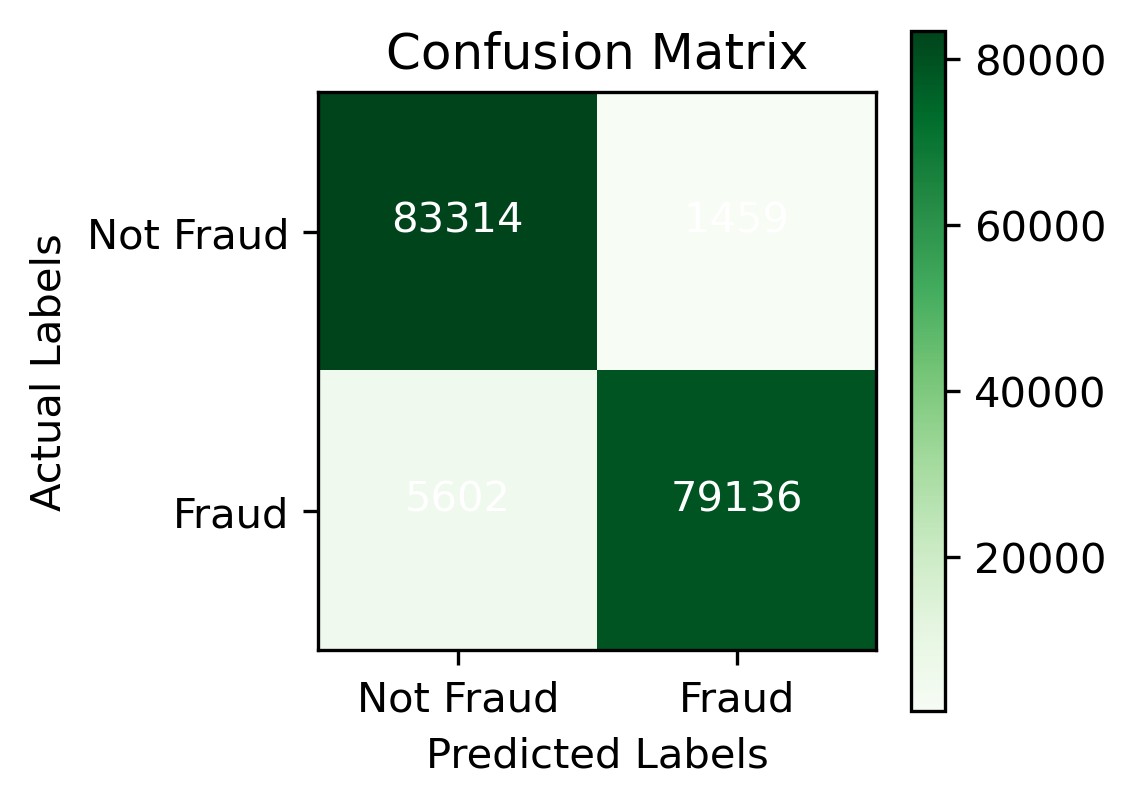

In [95]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)

In [97]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     84773
           1       0.98      0.93      0.96     84738

    accuracy                           0.96    169511
   macro avg       0.96      0.96      0.96    169511
weighted avg       0.96      0.96      0.96    169511



# Decision Tree

In [99]:
model_tree = DecisionTreeClassifier()

In [100]:
model_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [101]:
cm = confusion_matrix(y_test, model_tree.predict(X_test))

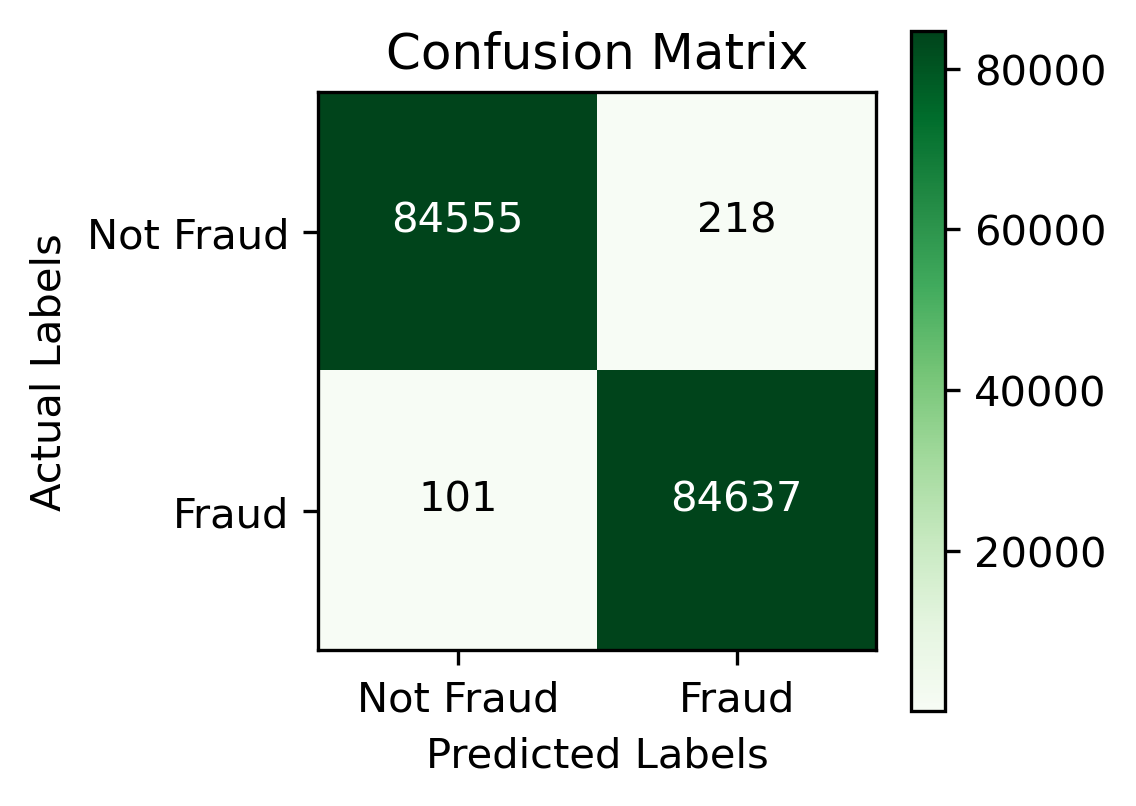

In [103]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)

In [104]:
print(classification_report(y_test, model_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84773
           1       1.00      1.00      1.00     84738

    accuracy                           1.00    169511
   macro avg       1.00      1.00      1.00    169511
weighted avg       1.00      1.00      1.00    169511



In [105]:
accuracy_score(y_test,model_tree.predict(X_test))

0.9981181162284454

# CatBoost

In [106]:
model_cat = CatBoostClassifier()
model_cat.fit(X_train, y_train)

Learning rate set to 0.132412
0:	learn: 0.4526018	total: 113ms	remaining: 1m 53s
1:	learn: 0.3095932	total: 239ms	remaining: 1m 59s
2:	learn: 0.2297495	total: 360ms	remaining: 1m 59s
3:	learn: 0.1867600	total: 476ms	remaining: 1m 58s
4:	learn: 0.1586423	total: 619ms	remaining: 2m 3s
5:	learn: 0.1379449	total: 773ms	remaining: 2m 7s
6:	learn: 0.1243078	total: 915ms	remaining: 2m 9s
7:	learn: 0.1121311	total: 1.03s	remaining: 2m 8s
8:	learn: 0.1042014	total: 1.14s	remaining: 2m 5s
9:	learn: 0.0990695	total: 1.27s	remaining: 2m 5s
10:	learn: 0.0947325	total: 1.39s	remaining: 2m 4s
11:	learn: 0.0892186	total: 1.5s	remaining: 2m 3s
12:	learn: 0.0861112	total: 1.6s	remaining: 2m 1s
13:	learn: 0.0833715	total: 1.72s	remaining: 2m
14:	learn: 0.0793527	total: 1.84s	remaining: 2m
15:	learn: 0.0769361	total: 1.95s	remaining: 1m 59s
16:	learn: 0.0742597	total: 2.05s	remaining: 1m 58s
17:	learn: 0.0706270	total: 2.16s	remaining: 1m 57s
18:	learn: 0.0684446	total: 2.27s	remaining: 1m 57s
19:	learn: 

158:	learn: 0.0056342	total: 20.3s	remaining: 1m 47s
159:	learn: 0.0055663	total: 20.4s	remaining: 1m 47s
160:	learn: 0.0055168	total: 20.6s	remaining: 1m 47s
161:	learn: 0.0054490	total: 20.7s	remaining: 1m 47s
162:	learn: 0.0053426	total: 20.8s	remaining: 1m 46s
163:	learn: 0.0052644	total: 21s	remaining: 1m 46s
164:	learn: 0.0051814	total: 21.1s	remaining: 1m 47s
165:	learn: 0.0050770	total: 21.3s	remaining: 1m 46s
166:	learn: 0.0049764	total: 21.4s	remaining: 1m 46s
167:	learn: 0.0048855	total: 21.5s	remaining: 1m 46s
168:	learn: 0.0048204	total: 21.7s	remaining: 1m 46s
169:	learn: 0.0048038	total: 21.8s	remaining: 1m 46s
170:	learn: 0.0047653	total: 21.9s	remaining: 1m 46s
171:	learn: 0.0047253	total: 22s	remaining: 1m 46s
172:	learn: 0.0046746	total: 22.2s	remaining: 1m 46s
173:	learn: 0.0046469	total: 22.3s	remaining: 1m 45s
174:	learn: 0.0046131	total: 22.4s	remaining: 1m 45s
175:	learn: 0.0045583	total: 22.6s	remaining: 1m 45s
176:	learn: 0.0045177	total: 22.7s	remaining: 1m 4

315:	learn: 0.0042136	total: 36.1s	remaining: 1m 18s
316:	learn: 0.0042136	total: 36.1s	remaining: 1m 17s
317:	learn: 0.0042136	total: 36.2s	remaining: 1m 17s
318:	learn: 0.0042136	total: 36.3s	remaining: 1m 17s
319:	learn: 0.0042136	total: 36.4s	remaining: 1m 17s
320:	learn: 0.0042136	total: 36.5s	remaining: 1m 17s
321:	learn: 0.0042136	total: 36.6s	remaining: 1m 17s
322:	learn: 0.0042136	total: 36.7s	remaining: 1m 16s
323:	learn: 0.0042136	total: 36.8s	remaining: 1m 16s
324:	learn: 0.0042136	total: 36.9s	remaining: 1m 16s
325:	learn: 0.0042136	total: 36.9s	remaining: 1m 16s
326:	learn: 0.0042136	total: 37.1s	remaining: 1m 16s
327:	learn: 0.0042136	total: 37.2s	remaining: 1m 16s
328:	learn: 0.0042136	total: 37.3s	remaining: 1m 16s
329:	learn: 0.0042136	total: 37.4s	remaining: 1m 15s
330:	learn: 0.0042136	total: 37.5s	remaining: 1m 15s
331:	learn: 0.0042136	total: 37.6s	remaining: 1m 15s
332:	learn: 0.0042136	total: 37.7s	remaining: 1m 15s
333:	learn: 0.0042136	total: 37.8s	remaining: 

474:	learn: 0.0041844	total: 50.5s	remaining: 55.8s
475:	learn: 0.0041844	total: 50.6s	remaining: 55.7s
476:	learn: 0.0041844	total: 50.7s	remaining: 55.6s
477:	learn: 0.0041844	total: 50.8s	remaining: 55.4s
478:	learn: 0.0041844	total: 50.9s	remaining: 55.3s
479:	learn: 0.0041844	total: 50.9s	remaining: 55.2s
480:	learn: 0.0041844	total: 51s	remaining: 55.1s
481:	learn: 0.0041844	total: 51.1s	remaining: 54.9s
482:	learn: 0.0041844	total: 51.2s	remaining: 54.8s
483:	learn: 0.0041844	total: 51.3s	remaining: 54.7s
484:	learn: 0.0041844	total: 51.3s	remaining: 54.5s
485:	learn: 0.0041844	total: 51.4s	remaining: 54.4s
486:	learn: 0.0041844	total: 51.5s	remaining: 54.3s
487:	learn: 0.0041844	total: 51.6s	remaining: 54.2s
488:	learn: 0.0041844	total: 51.7s	remaining: 54.1s
489:	learn: 0.0041844	total: 51.9s	remaining: 54s
490:	learn: 0.0041844	total: 52s	remaining: 53.9s
491:	learn: 0.0041844	total: 52.1s	remaining: 53.7s
492:	learn: 0.0041844	total: 52.1s	remaining: 53.6s
493:	learn: 0.0041

635:	learn: 0.0041844	total: 1m 4s	remaining: 37.2s
636:	learn: 0.0041844	total: 1m 5s	remaining: 37.1s
637:	learn: 0.0041844	total: 1m 5s	remaining: 36.9s
638:	learn: 0.0041844	total: 1m 5s	remaining: 36.8s
639:	learn: 0.0041844	total: 1m 5s	remaining: 36.7s
640:	learn: 0.0041844	total: 1m 5s	remaining: 36.6s
641:	learn: 0.0041844	total: 1m 5s	remaining: 36.5s
642:	learn: 0.0041844	total: 1m 5s	remaining: 36.4s
643:	learn: 0.0041844	total: 1m 5s	remaining: 36.3s
644:	learn: 0.0041844	total: 1m 5s	remaining: 36.2s
645:	learn: 0.0041844	total: 1m 5s	remaining: 36.1s
646:	learn: 0.0041844	total: 1m 5s	remaining: 36s
647:	learn: 0.0041844	total: 1m 5s	remaining: 35.8s
648:	learn: 0.0041844	total: 1m 6s	remaining: 35.7s
649:	learn: 0.0041844	total: 1m 6s	remaining: 35.6s
650:	learn: 0.0041844	total: 1m 6s	remaining: 35.5s
651:	learn: 0.0041844	total: 1m 6s	remaining: 35.4s
652:	learn: 0.0041844	total: 1m 6s	remaining: 35.3s
653:	learn: 0.0041844	total: 1m 6s	remaining: 35.2s
654:	learn: 0.

793:	learn: 0.0041591	total: 1m 20s	remaining: 20.9s
794:	learn: 0.0041591	total: 1m 20s	remaining: 20.8s
795:	learn: 0.0041591	total: 1m 20s	remaining: 20.7s
796:	learn: 0.0041459	total: 1m 20s	remaining: 20.6s
797:	learn: 0.0041458	total: 1m 20s	remaining: 20.5s
798:	learn: 0.0041458	total: 1m 21s	remaining: 20.4s
799:	learn: 0.0041458	total: 1m 21s	remaining: 20.3s
800:	learn: 0.0041458	total: 1m 21s	remaining: 20.2s
801:	learn: 0.0041458	total: 1m 21s	remaining: 20.1s
802:	learn: 0.0041458	total: 1m 21s	remaining: 20s
803:	learn: 0.0041458	total: 1m 21s	remaining: 19.9s
804:	learn: 0.0041458	total: 1m 21s	remaining: 19.8s
805:	learn: 0.0041458	total: 1m 21s	remaining: 19.7s
806:	learn: 0.0041458	total: 1m 21s	remaining: 19.6s
807:	learn: 0.0041457	total: 1m 22s	remaining: 19.5s
808:	learn: 0.0041457	total: 1m 22s	remaining: 19.4s
809:	learn: 0.0041457	total: 1m 22s	remaining: 19.3s
810:	learn: 0.0041457	total: 1m 22s	remaining: 19.2s
811:	learn: 0.0041457	total: 1m 22s	remaining: 1

951:	learn: 0.0038307	total: 1m 36s	remaining: 4.85s
952:	learn: 0.0038307	total: 1m 36s	remaining: 4.75s
953:	learn: 0.0038307	total: 1m 36s	remaining: 4.65s
954:	learn: 0.0037814	total: 1m 36s	remaining: 4.55s
955:	learn: 0.0037272	total: 1m 36s	remaining: 4.45s
956:	learn: 0.0037272	total: 1m 36s	remaining: 4.35s
957:	learn: 0.0037272	total: 1m 36s	remaining: 4.25s
958:	learn: 0.0037272	total: 1m 36s	remaining: 4.14s
959:	learn: 0.0037272	total: 1m 37s	remaining: 4.04s
960:	learn: 0.0037271	total: 1m 37s	remaining: 3.94s
961:	learn: 0.0037271	total: 1m 37s	remaining: 3.84s
962:	learn: 0.0037271	total: 1m 37s	remaining: 3.74s
963:	learn: 0.0037271	total: 1m 37s	remaining: 3.64s
964:	learn: 0.0037271	total: 1m 37s	remaining: 3.54s
965:	learn: 0.0037271	total: 1m 37s	remaining: 3.44s
966:	learn: 0.0037271	total: 1m 37s	remaining: 3.34s
967:	learn: 0.0037271	total: 1m 37s	remaining: 3.23s
968:	learn: 0.0037271	total: 1m 37s	remaining: 3.13s
969:	learn: 0.0037271	total: 1m 38s	remaining:

In [107]:
cm = confusion_matrix(y_test, model_cat.predict(X_test))

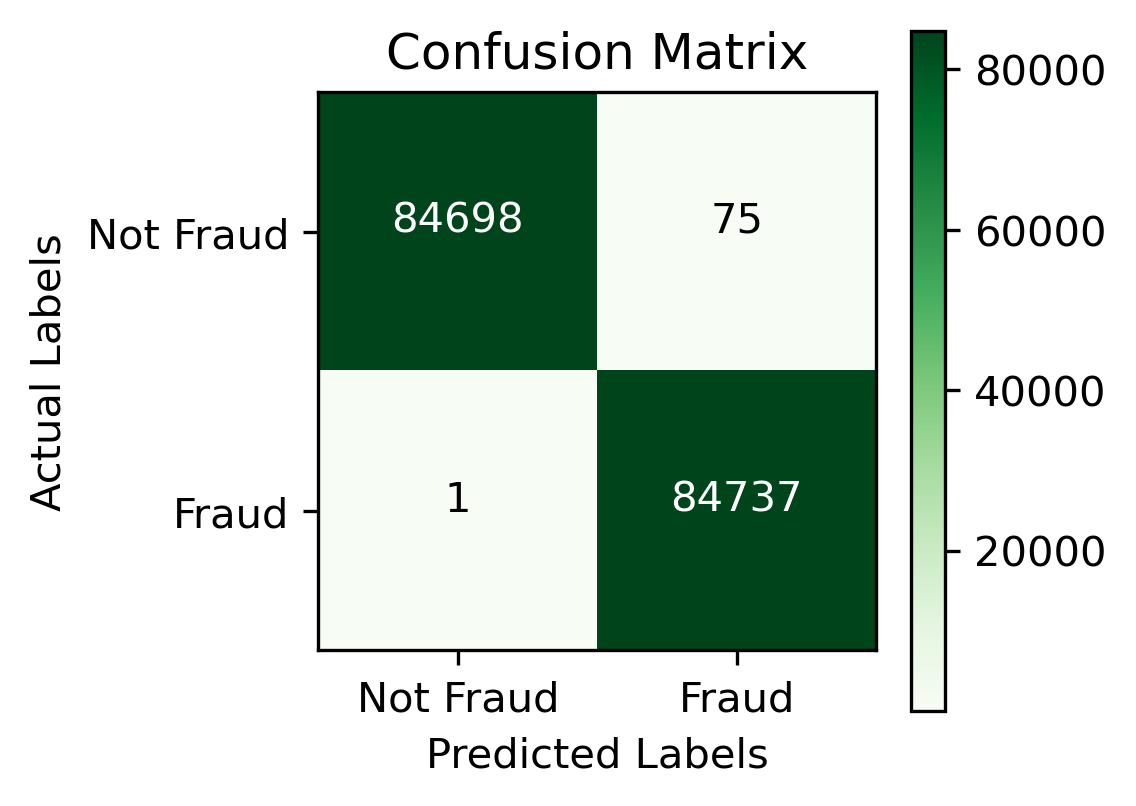

In [108]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)

In [109]:
print(classification_report(y_test, model_cat.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84773
           1       1.00      1.00      1.00     84738

    accuracy                           1.00    169511
   macro avg       1.00      1.00      1.00    169511
weighted avg       1.00      1.00      1.00    169511



# XGBoost

In [110]:
model_xgb = xgb.XGBClassifier()

In [111]:
model_xgb.fit(X_train, y_train)

F:\Ana3\envs\tensorflow_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
F:\Ana3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[21:55:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [112]:
cm = confusion_matrix(y_test, model_xgb.predict(X_test))

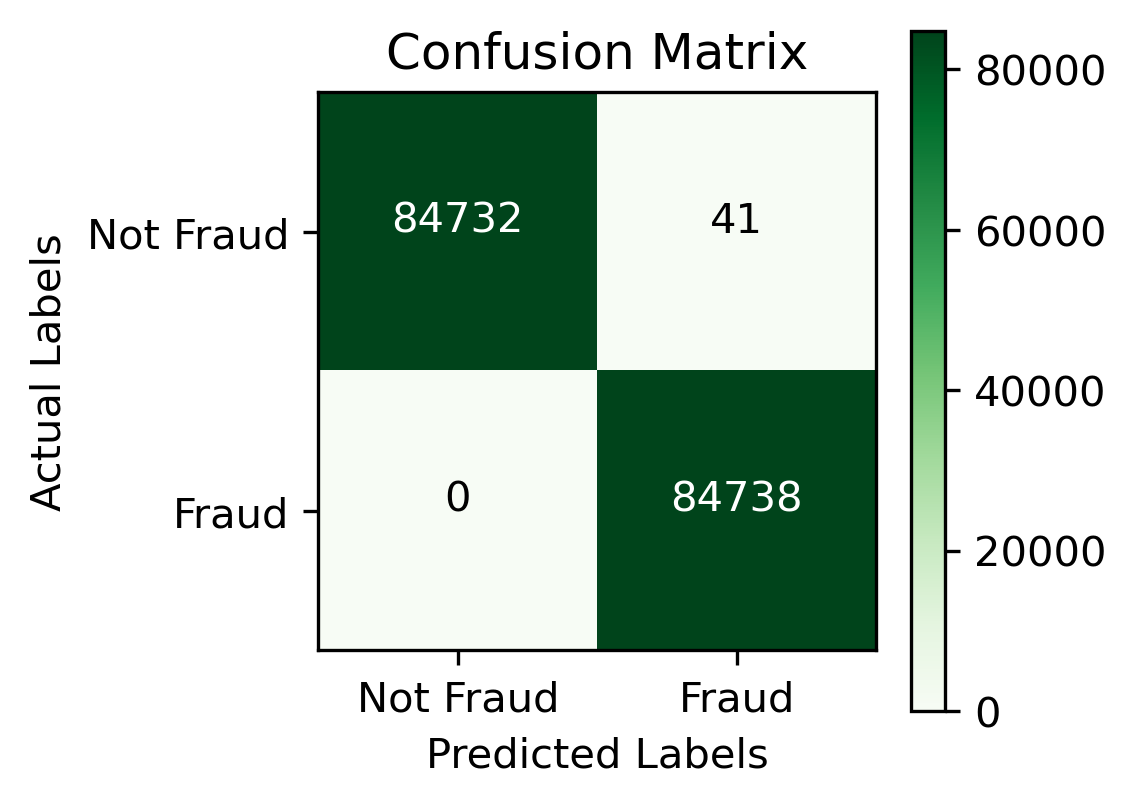

In [114]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)

In [113]:
print(classification_report(y_test, model_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84773
           1       1.00      1.00      1.00     84738

    accuracy                           1.00    169511
   macro avg       1.00      1.00      1.00    169511
weighted avg       1.00      1.00      1.00    169511

